# Introduction

In the following notebook, I will be performing an EDA of processed Reviews Data to get a better understanding of positive and negative reviews before finally moving onto modelling.

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set notebook preferences**

In [2]:
#Set pandas preferences
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 200)

#Set plot style
plt.style.use('Solarize_Light2')

#Surpress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**Read in data**

In [3]:
#Set path
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0616_Reviews_Processed.csv', index_col=0)

#Remove brackets and commas from tokens
df['tokens_clean'] = df['tokens_clean'].replace(r'[\[\]]','', regex = True)
df['tokens_clean'] = df['tokens_clean'].replace(r'[\',]','', regex = True)

**Preview data**

In [4]:
print('Data shape:', df.shape)
df.head()

Data shape: (36753, 9)


,comments,review_scores_rating,language,comments_normalized,tokens,tokens_clean,comments_word_count,review_label,tokens_pos_tags
7790,Paul has a super nice place and is a super nice guy. The apartment is extremely clean and has an excellent location nestled between the Mission and Noe Valley. Definitely recommend his apartment!,100.0,en,paul has a super nice place and is a super nice guy the apartment is extremely clean and has an excellent location nestled between the mission and noe valley definitely recommend his apartment,"['paul', 'has', 'a', 'super', 'nice', 'place', 'and', 'is', 'a', 'super', 'nice', 'guy', 'the', 'apartment', 'is', 'extremely', 'clean', 'and', 'has', 'an', 'excellent', 'location', 'nestled', 'between', 'the', 'mission', 'and', 'noe', 'valley', 'definitely', 'recommend', 'his', 'apartment']",paul super nice place super nice guy apartment extremely clean excellent location nestled mission noe valley definitely recommend apartment,33,great,"[('paul', 'NN'), ('super', 'NN'), ('nice', 'JJ'), ('place', 'NN'), ('super', 'JJ'), ('nice', 'JJ'), ('guy', 'NN'), ('apartment', 'NN'), ('extremely', 'RB'), ('clean', 'JJ'), ('excellent', 'JJ'), ('location', 'NN'), ('nestled', 'VBN'), ('mission', 'NN'), ('noe', 'FW'), ('valley', 'NN'), ('definitely', 'RB'), ('recommend', 'JJ'), ('apartment', 'NN')]"
10317,Did not stay here. There was a challenge that was not resolved. Inflexible personality. I asked for and Lawrence refused to refund anything.. Mumbled under his breath how 'rediculous' we were.,20.0,en,did not stay here there was a challenge that was not resolved inflexible personality i asked for and lawrence refused to refund anything mumbled under his breath how rediculous we were,"['did', 'not', 'stay', 'here', 'there', 'was', 'a', 'challenge', 'that', 'was', 'not', 'resolved', 'inflexible', 'personality', 'i', 'asked', 'for', 'and', 'lawrence', 'refused', 'to', 'refund', 'anything', 'mumbled', 'under', 'his', 'breath', 'how', 'rediculous', 'we', 'were']",stay challenge resolved inflexible personality asked lawrence refused refund anything mumbled breath rediculous,32,poor,"[('stay', 'NN'), ('challenge', 'NN'), ('resolved', 'VBD'), ('inflexible', 'JJ'), ('personality', 'NN'), ('asked', 'VBD'), ('lawrence', 'NN'), ('refused', 'VBD'), ('refund', 'NN'), ('anything', 'NN'), ('mumbled', 'VBN'), ('breath', 'RB'), ('rediculous', 'JJ')]"
12146,"He's great. Location is perfect, especially if you have a bicycle.",60.0,en,he s great location is perfect especially if you have a bicycle,"['he', 's', 'great', 'location', 'is', 'perfect', 'especially', 'if', 'you', 'have', 'a', 'bicycle']",great location perfect especially bicycle,11,poor,"[('great', 'JJ'), ('location', 'NN'), ('perfect', 'NN'), ('especially', 'RB'), ('bicycle', 'VB')]"
27172,"Rebecca's studio is great. I felt completely at home with all the comforts and amenities that one could expect. Both the building and studio are very clean, modern and convenient to public transportation and San Francisco. Rebecca was very helpful and accommodating. I'd stay at her place again and would recommend anyone visiting SF to consider it as an excellent alternative to a hotel, especially if you prefer a modern accommodation.",80.0,en,rebecca s studio is great i felt completely at home with all the comforts and amenities that one could expect both the building and studio are very clean modern and convenient to public transportation and san francisco rebecca was very helpful and accommodating i d stay at her place again and would recommend anyone visiting sf to consider it as an excellent alternative to a hotel especially if you prefer a modern accommodation,"['rebecca', 's', 'studio', 'is', 'great', 'i', 'felt', 'completely', 'at', 'home', 'with', 'all', 'the', 'comforts', 'and', 'amenities', 'that', 'one', 'could', 'expect', 'both', 'the', 'building', 'and', 'studio', 'are', 'very', 'clean', 'modern', 'and', 'convenient', 'to', 'public', 'transportation', 'and', 'san', 'francisco',

**Data Types and General Data Metrics**

In [5]:
print(df.info())
print('\nData Metrics:\n{}\nVariance:\n{}'.format(df.describe(),df.var()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36753 entries, 7790 to 513317
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comments              36753 non-null  object 
 1   review_scores_rating  36753 non-null  float64
 2   language              36753 non-null  object 
 3   comments_normalized   36753 non-null  object 
 4   tokens                36753 non-null  object 
 5   tokens_clean          36753 non-null  object 
 6   comments_word_count   36753 non-null  int64  
 7   review_label          36753 non-null  object 
 8   tokens_pos_tags       36753 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.8+ MB
None

Data Metrics:
       review_scores_rating  comments_word_count
count          36753.000000         36753.000000
mean              96.100590            44.897668
std                5.579527            48.036226
min               20.000000             1.000000


# Exploratory Data Analysis

### Reveiw Scores Distributions

**Review Score Distributions by Review Label**

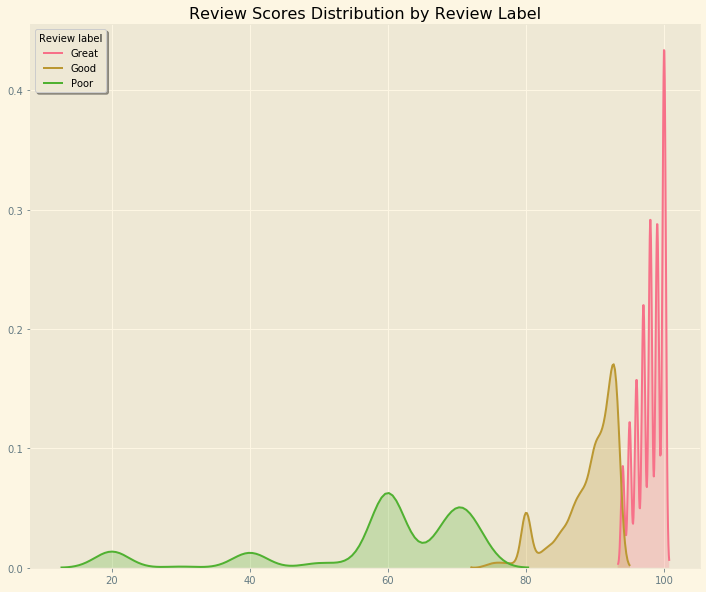

In [6]:
#Set figure
f, ax = plt.subplots(figsize = (12,10))

colors = sns.set_palette("husl")
g = sns.FacetGrid(df, hue="review_label", hue_order=['great','good','poor'])
g.map(sns.kdeplot, "review_scores_rating",shade = True,ax=ax,color=colors)

###Set plot Aesthetics###
#Title
ax.set_title('Review Scores Distribution by Review Label')

#Legend
ax.legend(title ='Review label',labels = ['Great','Good','Poor'], shadow = True, frameon = True)

#Close extra plot
plt.close();

**Word Count of reviews by Review Label**

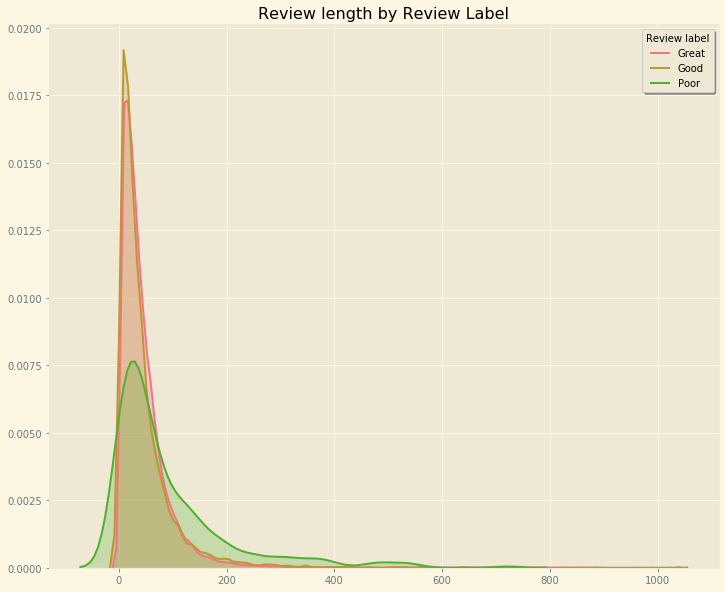

In [7]:
#Set figure
f, ax = plt.subplots(figsize = (12,10))

g = sns.FacetGrid(df, hue="review_label", hue_order=['great','good','poor'])
g.map(sns.kdeplot, "comments_word_count",shade = True,ax=ax,color=colors)

###Set plot Aesthetics###
#Title
ax.set_title('Review length by Review Label')

#Legend
ax.legend(title ='Review label',labels = ['Great','Good','Poor'], shadow = True, frameon = True)

#Close extra plot
plt.close();

### Word Frequency

**Data Preparation**

In [8]:
#Seperate reviews into great and poor
great_reviews = df.loc[df.review_label == 'great']
poor_reviews = df.loc[df.review_label == 'poor']

**Word Frequency for Great and Poor reviews**

C:\Users\kishe\Miniconda3\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


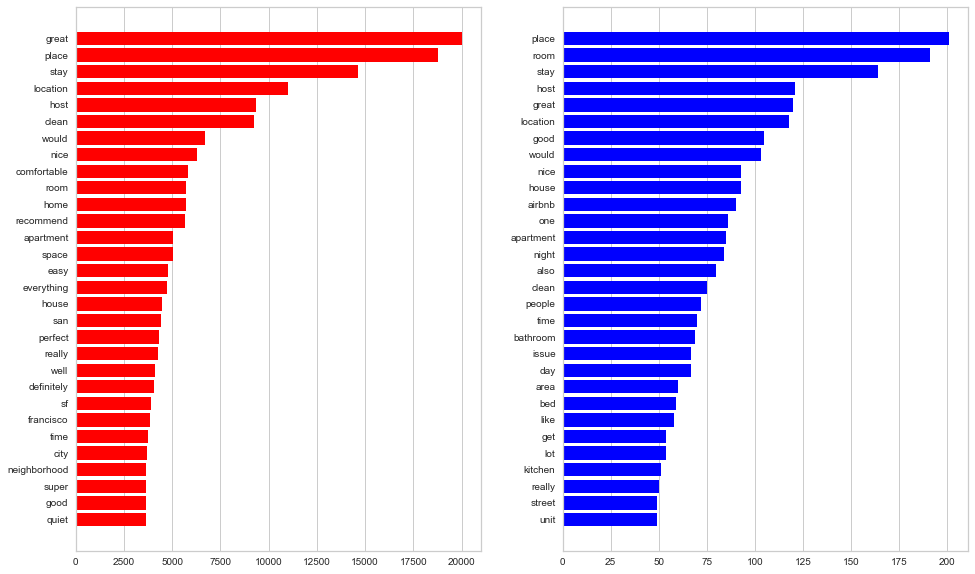

In [9]:
#Import libraries for word count visualization
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

#Init CountVectorizer
vectorizer = CountVectorizer()

#Get word counts for great reviews
great_docs =vectorizer.fit_transform(great_reviews.tokens_clean)
great_features = vectorizer.get_feature_names()

#Get word counts for poor reviews
poor_docs =vectorizer.fit_transform(poor_reviews.tokens_clean)
poor_features = vectorizer.get_feature_names()

#Set figure
f,ax = plt.subplots(1,2, figsize=(16,10))

#Plot Data
visualizer = FreqDistVisualizer(features=great_features, n=30, orient='h', color = 'red',ax = ax[0])
visualizer.fit(great_docs)
visualizer.poof;

visualizer = FreqDistVisualizer(features=poor_features, n=30, orient='h', color = 'blue', ax = ax[1])
visualizer.fit(poor_docs)
visualizer.poof;

###Set plot aesthetics###

**Word Cloud**

Text(0.5, 1.0, 'Negative Comments\n')

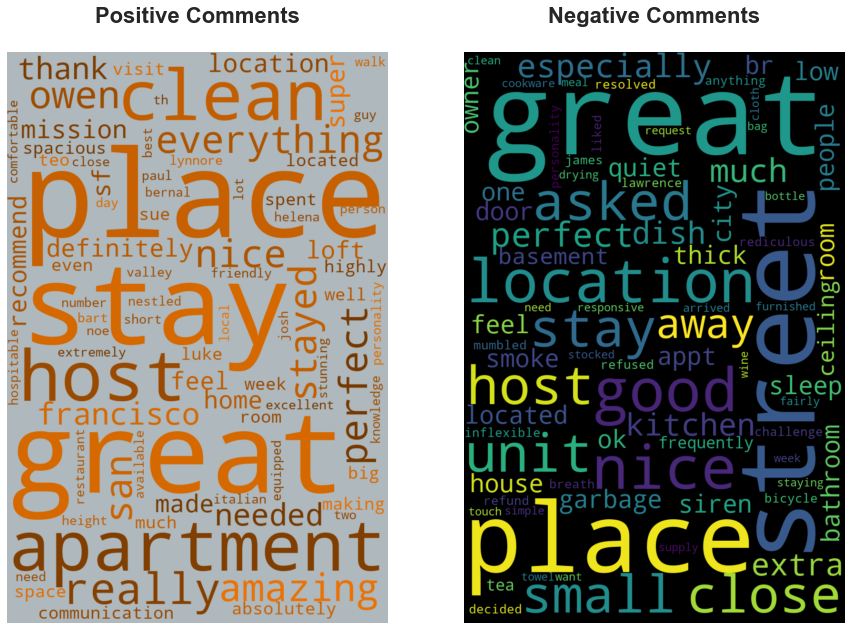

In [10]:
#Function that generates color font for wordcloud(from the internet somewhere)
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)


#Import wordcloud libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

great_wordcloud = WordCloud( width=800,max_words=80,
    min_font_size=10,collocations=False,background_color='#AFB8BD', color_func=random_color_func,
    height=1200,).generate(str(great_reviews['tokens_clean']))
    
poor_wordcloud = WordCloud( width=800,max_words=80,
    min_font_size=10, collocations=False,background_color='black',
    height=1200,).generate(str(poor_reviews['tokens_clean']))

#Plot data and set plot aesthetics
f,ax = plt.subplots(1,2,figsize = (15,15))

ax[0].imshow(great_wordcloud, interpolation = 'bilinear')
ax[0].axis("off")
ax[0].set_title('Positive Comments\n', fontsize=22, fontweight='semibold')


#Plot data and set plot aesthetics
ax[1].imshow(poor_wordcloud, interpolation = 'bilinear')
ax[1].axis("off")
ax[1].set_title('Negative Comments\n', fontsize=22, fontweight='semibold')

### Topic Modeling - Great Reviews

**Data Preparation**

In [11]:
#Read in libraries for Topic Modeling Data Prep
import gensim
import gensim.corpora as corpora
from nltk.tokenize import word_tokenize

#Convert tokens_clean list of sentences
sentences = great_reviews["tokens_clean"].values.tolist()

#Get a list of tokens
tokens = [word_tokenize(sentence) for sentence in sentences]

#Create a dictionary out of tokens
dictionary = corpora.Dictionary(tokens)

#Print dictionary details
print(dictionary)

#Convert each document in tokens into a BoW
corpus = [dictionary.doc2bow(token) for token in tokens]

C:\Users\kishe\Miniconda3\envs\NLP\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Dictionary(14752 unique tokens: ['apartment', 'clean', 'definitely', 'excellent', 'extremely']...)


**Determine Number of Topics for LDA Model**

In [12]:
#Import coherence_value_calculator
from coherence_score import coherence_value_calculator

#Get models and corresponding coherence scores
lda_models, coherence_scores = coherence_value_calculator(dictionary=dictionary, corpus=corpus, texts=tokens, start=2, step=3, limit = 30)

**Plot coherence scores**

Text(0.5, 0, 'Number of Topics')

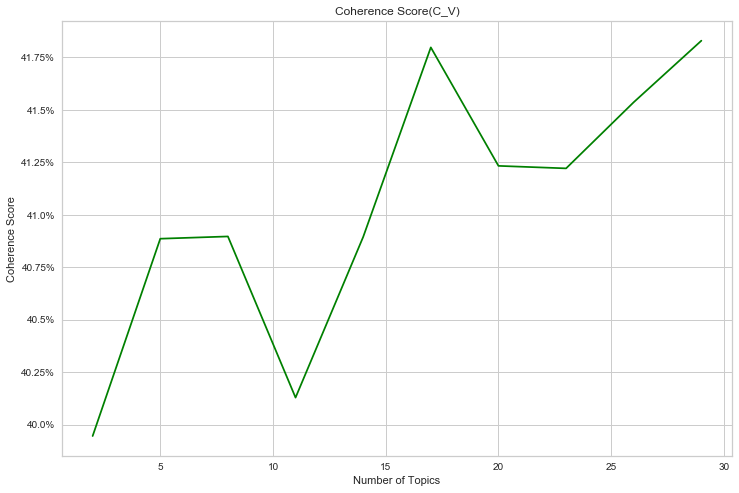

In [13]:
#Create fig
f, ax = plt.subplots(figsize = (12,8))

#Plot coherence scores
ax.plot(list(range(2,30,3)), coherence_scores, color = 'green')

###Set plot aesthetics##
#Title
ax.set_title('Coherence Score(C_V)')

#Axes
ax.set_ylabel('Coherence Score')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:}%".format(str(round((x * 100),2)))))

ax.set_xlabel('Number of Topics')

17 topics seems like a good bet

**Build LDA Model for Great Reviews**

In [14]:
#Import LdaMulticore and coherence model
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

#Deploy base model with 17 topics
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word = dictionary, num_topics=17, workers=3, random_state=24 )

#Compute Model Perplexity
print('\nBase Model Perplexity:', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

#Compute Model Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Base Model Coherence Score:', coherence_lda)


Base Model Perplexity: -7.138516306589808
Base Model Coherence Score: 0.41603063376922017


In [135]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_models[2], corpus, dictionary=lda_models[2].id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.026518  0.032903       1        1  21.008898
2     -0.008537 -0.038770       2        1  15.706958
7     -0.002846  0.020701       3        1  15.417110
1     -0.032409 -0.049462       4        1  12.346363
3      0.005896  0.031191       5        1  11.093907
6     -0.022551  0.006152       6        1  10.080737
0     -0.006460  0.007950       7        1  10.075213
5      0.093426 -0.010665       8        1   4.270811, topic_info=            Term          Freq         Total Category  logprob  loglift
12         place  21723.000000  21723.000000  Default  30.0000  30.0000
28          stay  16983.000000  16983.000000  Default  29.0000  29.0000
31         great  22109.000000  22109.000000  Default  28.0000  28.0000
131         good   4649.000000   4649.000000  Default  27.0000  27.0000
9           nice   7184.000000   7184.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
9           nice    221.098022   7184.897461   Topic8  -5.1286  -0.3278
442        space    206.158951   5962.668945   Topic8  -5.1985  -0.2113
290         easy    190.265854   5369.502930   Topic8  -5.2787  -0.1867
110  comfortable    192.866837   6176.890137   Topic8  -5.2652  -0.3132
93         close    179.695435   4011.813965   Topic8  -5.3359   0.0476

[694 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13659      6  0.935061       abide
7951       6  0.925051        abnb
16617      1  0.937086     absolut
120        1  0.512538  absolutely
120        2  0.082225  absolutely
...      ...       ...         ...
14524      8  0.762312          좋은
11353      8  0.806358          진짜
15943      4  0.181945           집
15943      5  0.045486           집
15943      8  0.727782           집

[1995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 8, 2, 4, 7, 1, 6])

### Topic Modeling - Poor Reviews

In [15]:
#Convert tokens_clean list of sentences
sentences = poor_reviews["tokens_clean"].values.tolist()

#Get a list of tokens
tokens = [word_tokenize(sentence) for sentence in sentences]

#Create a dictionary out of tokens
dictionary = corpora.Dictionary(tokens)

#Print dictionary details
print(dictionary)

#Convert each document in tokens into a BoW
corpus = [dictionary.doc2bow(token) for token in tokens]

Dictionary(2915 unique tokens: ['anything', 'asked', 'breath', 'challenge', 'inflexible']...)


**Determine Number of Topics for LDA Model**

In [16]:
#Import coherence_value_calculator
from coherence_score import coherence_value_calculator

#Get models and corresponding coherence scores
lda_models, coherence_scores = coherence_value_calculator(dictionary=dictionary, corpus=corpus, texts=tokens, start=2, step=3, limit = 30)

**Plot coherence scores**

Text(0.5, 0, 'Number of Topics')

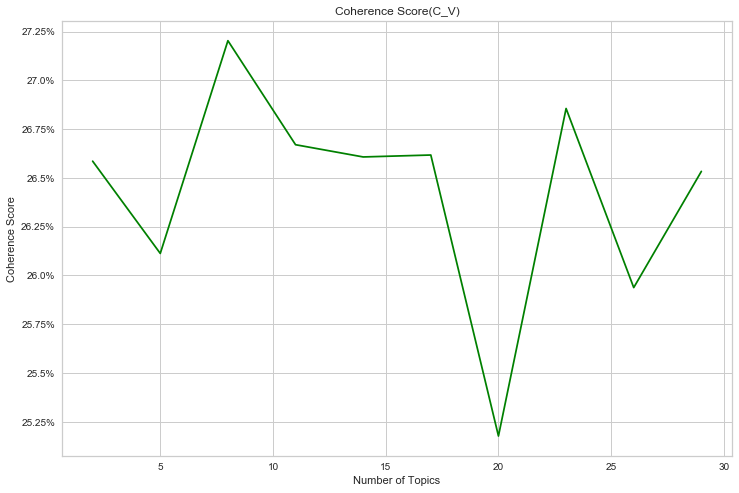

In [17]:
#Create fig
f, ax = plt.subplots(figsize = (12,8))

#Plot coherence scores
ax.plot(list(range(2,30,3)), coherence_scores, color = 'green')

###Set plot aesthetics##
#Title
ax.set_title('Coherence Score(C_V)')

#Axes
ax.set_ylabel('Coherence Score')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:}%".format(str(round((x * 100),2)))))

ax.set_xlabel('Number of Topics')

17 topics seems like a good bet

**Build LDA Model for Great Reviews**

In [18]:
#Import LdaMulticore and coherence model
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

#Deploy base model with 17 topics
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word = dictionary, num_topics=8, workers=3, random_state=42 )

#Compute Model Perplexity
print('\nBase Model Perplexity:', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

#Compute Model Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Base Model Coherence Score:', coherence_lda)


Base Model Perplexity: -8.034023212537177
Base Model Coherence Score: 0.2525461471374877


In [19]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_models[2], corpus, dictionary=lda_models[2].id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.016606 -0.026532       1        1  31.319275
5     -0.019726 -0.001526       2        1  19.162037
2     -0.031440 -0.013119       3        1  16.721382
7     -0.025869 -0.002809       4        1   8.635427
4      0.000786  0.020469       5        1   7.038270
3      0.054106 -0.039226       6        1   6.850500
6      0.014857  0.038583       7        1   6.262338
1      0.023893  0.024160       8        1   4.010775, topic_info=         Term        Freq       Total Category  logprob  loglift
65      place  164.000000  164.000000  Default  30.0000  30.0000
46       good   86.000000   86.000000  Default  29.0000  29.0000
16   location   99.000000   99.000000  Default  28.0000  28.0000
15      great  100.000000  100.000000  Default  27.0000  27.0000
30      clean   63.000000   63.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
58       need    1.584153   32.603268   Topic8  -5.8671   0.1918
92       unit    1.624800   38.689365   Topic8  -5.8417   0.0460
228       day    1.663437   57.331692   Topic8  -5.8182  -0.3238
138      room    1.730853  170.404984   Topic8  -5.7785  -1.3734
105  bathroom    1.569718   57.950916   Topic8  -5.8762  -0.3925

[629 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1025      1  0.354941     ad
1025      2  0.354941     ad
1025      8  0.354941     ad
1480      3  0.439760  adult
1480      4  0.439760  adult
...     ...       ...    ...
1268      2  0.307667   zeus
1268      3  0.153834   zeus
1268      4  0.076917   zeus
1268      7  0.153834   zeus
1268      8  0.076917   zeus

[1302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 8, 5, 4, 7, 2])